## Unit root testing
1. [Abbreviations & definitions](#abreviations_definitions)
2. [Load and inspect](#load_and_inspect)
3. [Augmented Dicky-Fuller test](#ADF_test)
4. [Kwiatkowski-Phillips-Schmidt-Shin test](#KPSS_test)
5. [TODO](#TODO)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count

<a name="load_and_inspect"></a>
### 2. Load and inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs

import numpy as np
import pandas as pd
import matplotlib
import statsmodels.api as sm

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore
print(f'Statsmodels: {sm.__version__}')

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3
Matplotlib: 3.6.3
Statsmodels: 0.13.2


In [2]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/train.csv.zip', compression='zip')

# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


<a name="ADF_test"></a>
### 3. Augmented Dicky-Fuller test

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):

    adf_test_result = adfuller(timeseries, autolag="AIC")

    return adf_test_result[1]

In [4]:
# Get list of unique cfips
cfips_list = training_df['cfips'].drop_duplicates(keep='first').to_list()

# Holder for results
pvals = {
    'cfips': [],
    'ADF_pval': []
}

# Loop on counties and ADF test each
for cfips in cfips_list:
    timeseries = training_df[training_df['cfips'] == cfips]
    
    pvals['cfips'].append(cfips)
    pvals['ADF_pval'].append(adf_test(timeseries['microbusiness_density']))

pvals_df = pd.DataFrame.from_dict(pvals)

pvals_df['ADF_pval'].describe()

count    3135.000000
mean        0.496025
std         0.319571
min         0.000000
25%         0.208972
50%         0.508429
75%         0.777935
max         1.000000
Name: ADF_pval, dtype: float64

In [5]:
pvals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cfips     3135 non-null   int64  
 1   ADF_pval  3135 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.1 KB


In [6]:
adf_pvals = pvals_df['ADF_pval']
nonzero_pvals = adf_pvals[adf_pvals > 0]

print(f'Non-zero pvalues: {len(nonzero_pvals)}')
print(f'Zero p-values: {len(pvals_df) - len(nonzero_pvals)}')

Non-zero pvalues: 3132
Zero p-values: 3


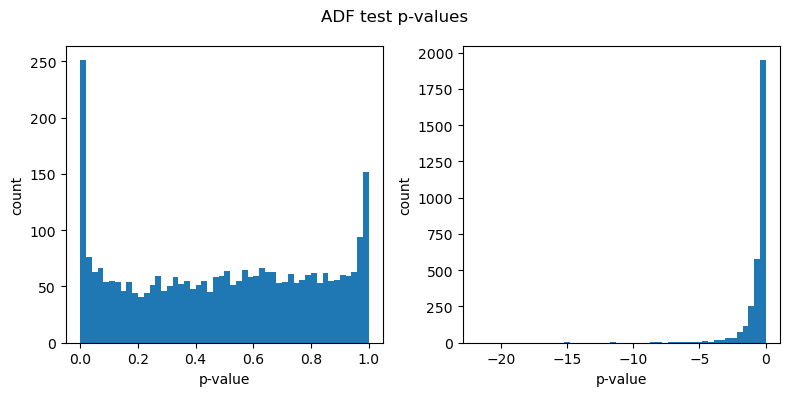

In [7]:
plt = plot_funcs.two_panel_histogram(
    data = nonzero_pvals,
    main_title = 'ADF test p-values',
    linear_plot_x_label = 'p-value',
    log10_plot_x_label = 'p-value',
    bins = 50,
    fig_x_dim = 8,
    fig_y_dim = 4
)

plt.show()

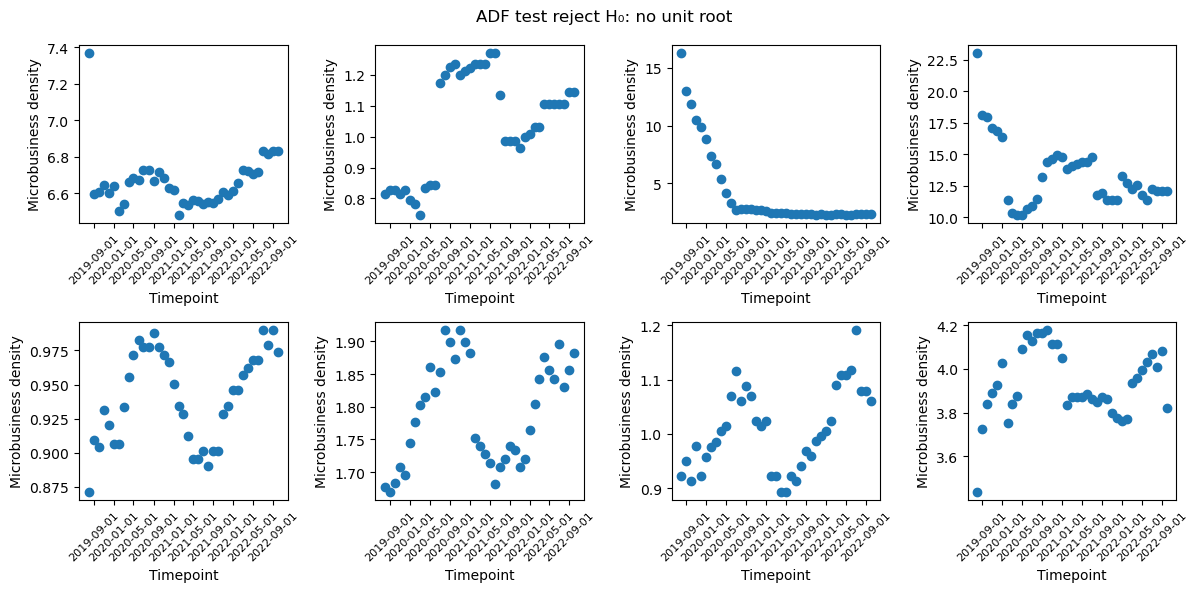

In [8]:
ADF_null_rejected = pvals_df[pvals_df['ADF_pval'] < 0.05].head(20).sort_values(['ADF_pval'])

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = ADF_null_rejected['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test reject H\N{SUBSCRIPT ZERO}: no unit root'
)

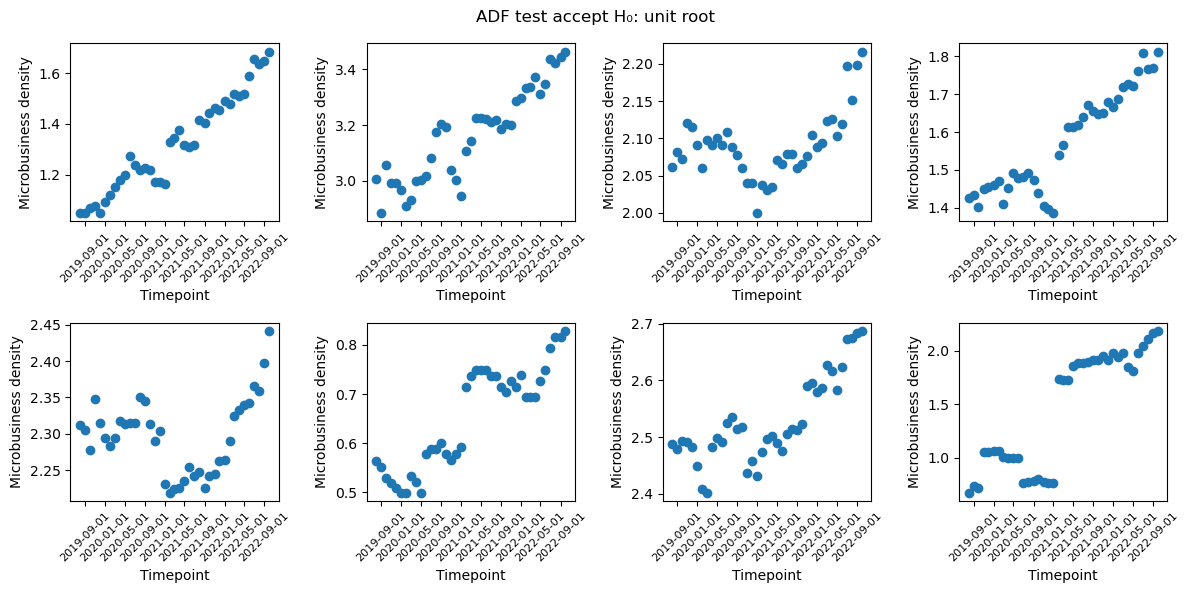

In [9]:
ADF_null_accepted = pvals_df[pvals_df['ADF_pval'] >= 0.05].head(20).sort_values(['ADF_pval'], ascending=False)

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = ADF_null_accepted['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test accept H\N{SUBSCRIPT ZERO}: unit root'
)

<a name="KPSS_test"></a>
### 4. Kwiatkowski-Phillips-Schmidt-Shin test

In [10]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    kpss_test_result = kpss(timeseries, regression="c", nlags="auto")

    return kpss_test_result[1]

In [11]:
# Add column to holder for results
pvals['KPSS_pval'] = []

# Loop on counties and KPSS test each
for cfips in cfips_list:
    timeseries = training_df[training_df['cfips'] == cfips]

    kpss_test_result = kpss_test(timeseries['microbusiness_density'])
    pvals['KPSS_pval'].append(kpss_test_result)

pvals_df = pd.DataFrame.from_dict(pvals)
pvals_df['KPSS_pval'].describe()

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: 

count    3135.000000
mean        0.045312
std         0.037969
min         0.010000
25%         0.010001
50%         0.023991
75%         0.100000
max         0.100000
Name: KPSS_pval, dtype: float64

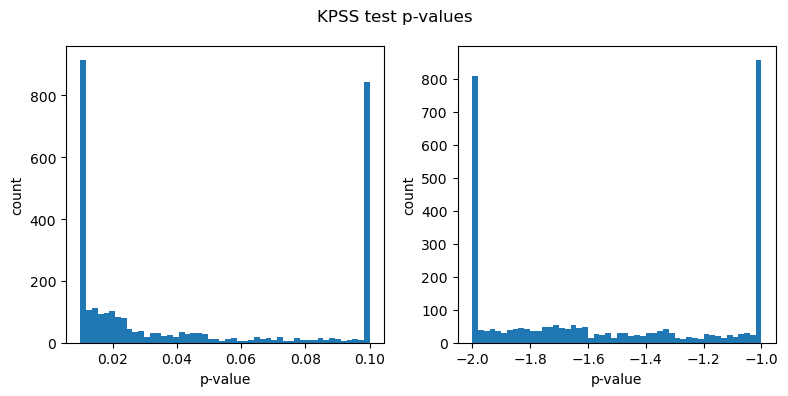

In [12]:
plt = plot_funcs.two_panel_histogram(
    data = pvals_df['KPSS_pval'],
    main_title = 'KPSS test p-values',
    linear_plot_x_label = 'p-value',
    log10_plot_x_label = 'p-value',
    bins = 50,
    fig_x_dim = 8,
    fig_y_dim = 4
)

plt.show()

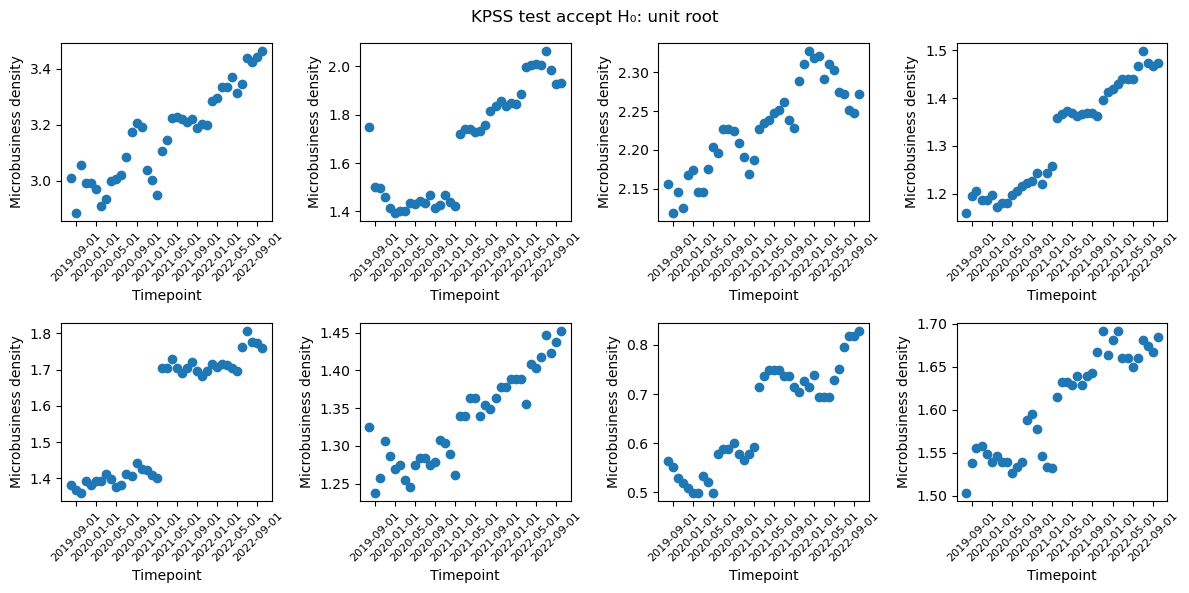

In [13]:
KPSS_null_accepted = pvals_df[pvals_df['KPSS_pval'] < 0.05].head(20).sort_values(['KPSS_pval'])

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = KPSS_null_accepted['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'KPSS test accept H\N{SUBSCRIPT ZERO}: unit root'
)

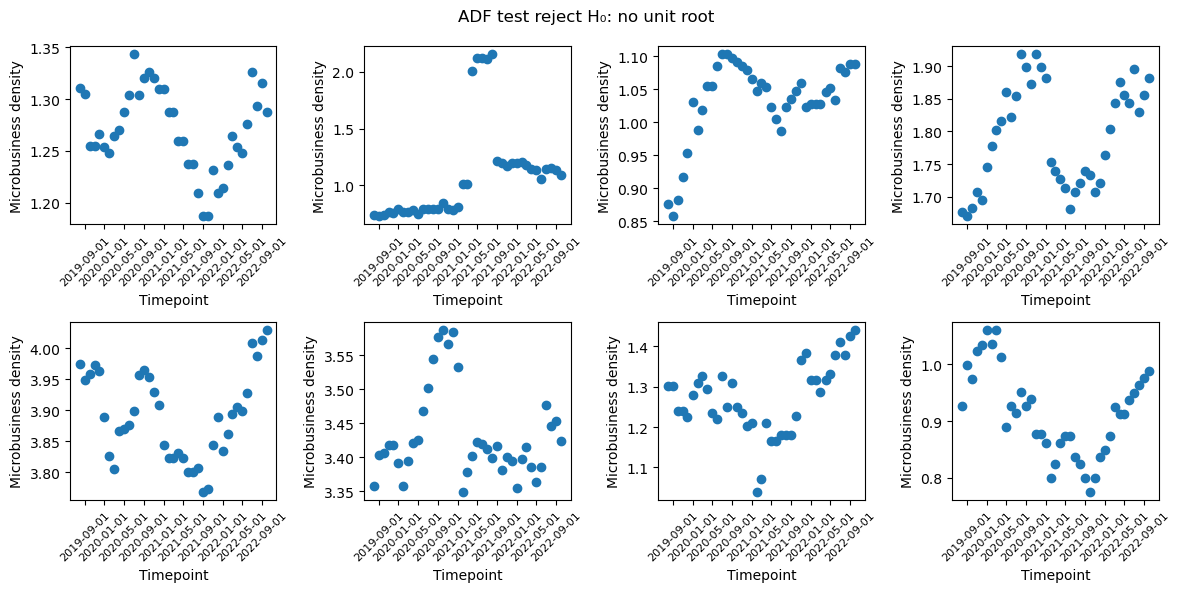

In [14]:
KPSS_null_rejected = pvals_df[pvals_df['KPSS_pval'] >= 0.05].head(20).sort_values(['KPSS_pval'], ascending=False)

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = KPSS_null_rejected['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test reject H\N{SUBSCRIPT ZERO}: no unit root'
)

<a name="TODO"></a>
### 5. TODO
1. Check interpretation of null hypothesis.
2. Make 'confusion-matrix' style plot showing how many counties accept/reject H<sub>0</sub> for each test.
4. Add difference de-trending (whole dataset? just relevant counties?).